# Тесты с генетическим алгоритмом (Скрещивание)

Требуется подобрать такие параметры НРС, чтобы при заданных условиях (например, при требуемом расходе воды и подаче на требуемое расстояние), состав сил и средств был минимальный.

Критерии оптимизации (пример для расхода и расстояния):


$$
|\sum_{i=1}^{n}{Q_i}-Q_{треб.}|\longrightarrow min
$$

$$
|L_{НРС}-L_{треб.}|\longrightarrow min
$$



Мутации добавления отдельных элементов невозможны, поэтому нужно делать мутации блоками:

* ствол с рукавной линией
* магистральная рукавная линия

Нет, не так!

Типы мутаций:

* Разбить составной элемент, вставив другой элемент,
* Удалить элемент
* Изменить параметры элемента (количество рукавов, тип рукавов)
* Добавить рабочую рукавную линию

Основные категории элементов НРС:

* Насос ПА (Pump)
* напорная рукавная линия (Hose)
* всасывающая рукавная линия (InHose)
* разветвление (Splitter)
* водосборник (Joiner)
* ствол (Nozzle)


Также нужно добавить элемент который будет очищать мусор в модели.

## Обертка над NRS которая будет реализовывать более тонкие функции ГА

In [1]:
from nrs import NRS_Model, Element, NRS_Revision, NRS_Observer_E    # классы НРС
from nrs import NRS_Data                                            # Табличные данные НРС
from nrs import q_out_simple, q_out_nozzle                          # модели расчета параметров
import matplotlib.pyplot as plt                                     # библиотеки для отрисовки получаемых данных
import networkx as nx
import numpy as np
import random
import copy
from functools import reduce

import logging
logger = logging.getLogger('NRS')
# logger.setLevel(logging.DEBUG)
# logging.basicConfig(level=logging.DEBUG)

In [2]:
def print_NRS_graph(model):
    '''
    Построение графа НРС
    '''
    # Цвета вершин
    colors={
        'GA_Element_Pump': 'gray',
        'GA_Element_Hose': 'blue',
        'GA_Element_InHose': 'black',
        'GA_Element_Splitter': 'green',
        'GA_Element_Joiner': 'green',
        'GA_Element_Nozzle': 'red',
    }

    try:
        G = nx.DiGraph()
        # Узлы - на каждый элемент
        for elmnt in model.elmnts:
            G.add_node(elmnt.name, q=elmnt.q)
        # Ребра - на каждую связь
        for elmnt in model.elmnts:
            for elmnt_next in elmnt.elements_next:
                G.add_edge(elmnt.name, elmnt_next.name, L=elmnt.get_L())

        # Расчет расстояния до элементов
        for elmnt in model.elmnts_in:
            paths = nx.shortest_path_length(G, source = elmnt.name, weight='L')
            nx.set_node_attributes(G, paths, 'L')   # Здесь нужна другая логика
            print(f'Расстояние до {elmnt.name} {max(paths.values())} м')    

        # Печать графа НРС с позициями
        pos={}
        pos_list=[]
        level=0
        for eo in model.elmnts_in:
            v = eo.name
            spl = dict(nx.single_source_shortest_path_length(G, v))
            for nd, p in spl.items():
                if not nd in pos.keys():
                    level_rize=level
                    cpos = (p,level_rize)
                    while cpos in pos_list:
                        level_rize+=1
                        cpos = (p,level_rize)
                    pos[nd]=cpos
                    pos_list.append(cpos)
            level+=1

        # nc = [nd[1]['L'] for nd in list(G.nodes(data=True))]
        # nx.draw(G, pos=pos, with_labels=True, node_color=nc)
        nc = [colors[e.id] for e in model.elmnts]
        nx.draw(G, pos=pos, with_labels=True, node_color=nc)
        plt.show()

        return G
    except:
        print('Полный граф изобразить не возможно, будет отображен упрощенный')
        return print_NRS_graph_simple(model)

def print_NRS_graph_simple(model):
    '''
    Построение графа НРС
    '''
    G = nx.DiGraph()
    # Узлы - на каждый элемент
    for elmnt in model.elmnts:
        G.add_node(elmnt.name, q=elmnt.q)
    # Ребра - на каждую связь
    for elmnt in model.elmnts:
        for elmnt_next in elmnt.elements_next:
            G.add_edge(elmnt.name, elmnt_next.name)

    nx.draw(G, with_labels=True)
    plt.show()

    return G
# from workFolder.nrs import q_out_simple

#=========================================== Классы модели ГА ==============================================
class GA_model(NRS_Model):
    '''
    Класс модели НРС адаптированный для работы ГА
    '''
    def __init__(self, name):
        super().__init__(name)

    def appendElement(self, elmnt):
        
        # super().appendElement(elmnt)
        name_prefixes={
            'GA_Element_Pump': 'Н',
            'GA_Element_Hose': 'НРЛ',
            'GA_Element_InHose': 'ВРЛ',
            'GA_Element_Splitter': 'Р', 
            'GA_Element_Joiner': 'ВС',
            'GA_Element_Nozzle': 'С',
        }
        if elmnt.name=='': elmnt.name=name_prefixes[elmnt.id]+str(self.counter)
            
        return super().appendElement(elmnt)

    def crossing(self, pair_model):
        return self

    def mutate(self, mutation_count=1):
        '''
        Мутация элементов модели
        '''
        for _ in range(mutation_count):
            random.choice(self.elmnts).mutate()


    def check_pumps(self):
        '''
        Проверяет пожарные автомобили. 
        Для тех из них у которых есть только элементы на выход устанавливается e_type `0` (in).
        Для тех у кого имеются и те и те, ставится e_type `1` (inter).
        '''
        for elmnt in self.elmnts:
            if isinstance(elmnt, GA_Element_Pump):
                e_in = len(elmnt.elements_previous)
                e_out = len(elmnt.elements_next)
                if e_in==0 and e_out>0:
                    elmnt.type = 0
                if e_in>0 and e_out>0:
                    elmnt.type = 1
        return self
    

class GA_Element_Pump(Element):
    '''
    Класс элемента `Пожарного автомобиля с насосом` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type, H_min=10, Q_min=0, H_max=100, Q_max=40, 
        q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=0, ri=2, ro=2, q_out=...):
        
        self.id = 'GA_Element_Pump'
        self.H_min = H_min
        self.H_max = H_max
        self.Q_min = Q_min
        self.Q_max = Q_max
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def set_H_add(self, H_add):
        if H_add > self.H_max:
            self.H_add = self.H_max
        else:
            self.H_add = H_add
        if H_add <= self.H_min:
            self.H_add = self.H_min
        else:
            self.H_add = H_add

    def mutate(self):
        mutation_case = random.choices([0,1,2,3],weights=[4,2,1,1])[0]
        # мутация напора
        if mutation_case==0:
            change_val = random.choice([-5,5])
            # print('H added')
            self.H_add+=change_val
        # Мутация производительности насоса
        if mutation_case==1:
            change_val = random.choice([40,60,70,100])
            self.Q_max = change_val
        # Мутация количества напорных патрубков
        if mutation_case==2:
            change_val = random.choice([2,4])
            self.set_ro(change_val)
        # Мутация всасывающих патрубков
        if mutation_case==3:
            change_val = random.choice([1,2,3,4])
            self.set_ri(change_val)




class GA_Element_Hose(Element):
    '''
    Класс элемента `Рукавной линии` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, d='51', q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=20, ri=1, ro=1, q_out=...):
        self.id = 'GA_Element_Hose'
        self.d=d
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        mutation_case = random.choice([0,1])
        # мутация количества
        if mutation_case==0:
            change_val = random.choice([i for i in range(-5,5)])
            if self.n+change_val>0:
                self.n = self.n+change_val
        # мутация диаметра
        if mutation_case==1:
            new_d=random.choice(list(NRS_Data.ss.keys()))
            self.d = new_d
            self.s = NRS_Data.ss[new_d]
        # мутация типа

        # разбиение

class GA_Element_InHose(Element):
    '''
    Класс элемента `Всасывающей рукавной линии` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=4, ri=1, ro=1, q_out=...):
        self.id = 'GA_Element_InHose'
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        pass

class GA_Element_Splitter(Element):
    '''
    Класс элемента `Разветвление` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=0, ri=1, ro=3, q_out=...):
        self.id = 'GA_Element_Splitter'
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        # мутация количества выходов
        change_val = random.choice([2,3,4,5])
        # if change_val < self.ro:
        #     print('Удаляется', self.name)
        self.set_ro(change_val)

class GA_Element_Joiner(Element):
    '''
    Класс элемента `Водосборник` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=0, ri=2, ro=1, q_out=...):
        self.id = 'GA_Element_Joiner'
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        # мутация количества входов
        change_val = random.choice([2,3,4,5])
        self.set_ri(change_val)

class GA_Element_Nozzle(Element):
    '''
    Класс элемента `Ствол` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, n_type='Б', q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=0, ri=1, ro=0, q_out=...):
        '''
        `n_type` - тип ствола. `Б` - ручной ствол Б, `А` - ручной ствол А, `Л` - лафетный переносной, `ЛА` - лафетный автомобильный.
        '''
        self.id = 'GA_Element_Nozzle'
        self.n_type = n_type
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        # mutation_case = random.choice([0,1])
        # Мутация типа ствола
        change_val = random.choice(['А','Б','Л'])
        self.n_type = change_val
        if change_val=='А':
            self.p = NRS_Revision.calc_p(7.4, 40)
        if change_val=='Б':
            self.p = NRS_Revision.calc_p(3.7, 40)
        if change_val=='Л':
            self.p = NRS_Revision.calc_p(16, 40)


# Правила соединения элементов
# Классы которые могут быть присоединены после элемента
allowed_append_classes = {
        'GA_Element_Pump': (GA_Element_Hose),
        'GA_Element_Hose': (GA_Element_Pump,GA_Element_Hose,GA_Element_Nozzle,GA_Element_Joiner,GA_Element_Splitter),
        'GA_Element_InHose': (GA_Element_Pump),
        'GA_Element_Splitter': (GA_Element_Hose), #,GA_Element_Splitter),
        'GA_Element_Joiner': (GA_Element_Pump,GA_Element_Hose,GA_Element_Nozzle,GA_Element_Splitter),
        'GA_Element_Nozzle': (),
    }
# Классы которые могут быть присоединены перед элементом
allowed_prepend_classes = {
        'GA_Element_Pump': (GA_Element_Hose,GA_Element_Joiner,GA_Element_InHose),
        'GA_Element_Hose': (GA_Element_Pump,GA_Element_Hose,GA_Element_Joiner,GA_Element_Splitter),
        'GA_Element_InHose': (),
        'GA_Element_Splitter': (GA_Element_Hose,GA_Element_Joiner,GA_Element_Splitter),
        'GA_Element_Joiner': (GA_Element_Hose),
        'GA_Element_Nozzle': (GA_Element_Hose,GA_Element_Joiner),
    }



#=====================================Оценщик=====================================================================================================
class Appraiser(NRS_Revision):
    '''
    Класс-оценщик состояния модели
    '''
    
    @staticmethod
    def print_GA_NRS_model_elements_state(model:GA_model):
        print('='*80)
        print(model.name)
        print('='*80)
        
        for elmnt in model.elmnts:
            if isinstance(elmnt, GA_Element_Pump):
                print(f'Насос ({elmnt.name}); напор: {elmnt.H_add} м; производительность: {elmnt.q} л/с; напор макс.: {elmnt.H_max}')
        print('')
        for elmnt in model.elmnts:
            if isinstance(elmnt, GA_Element_Hose):
                print(f'Рукавная линия ({elmnt.name}), длина: {elmnt.get_L()} м; диаметр: {elmnt.d} мм; сопротивление {elmnt.s}; потеря напора: {elmnt.h} м')
        print('')
        for elmnt in model.elmnts:
            if isinstance(elmnt, GA_Element_Nozzle):
                print(f'Ствол ({elmnt.name}): "{elmnt.n_type}"; проводимость: {elmnt.p}; напор: {elmnt.H_in}, м; расход: {elmnt.q}, л/с')

    @staticmethod
    def get_G(model:GA_model):
        G = nx.DiGraph()

        # Узлы - на каждый элемент
        for elmnt in model.elmnts:
            G.add_node(elmnt.name, q=elmnt.q)
        # Ребра - на каждую связь
        for elmnt in model.elmnts:
            for elmnt_next in elmnt.elements_next:
                G.add_edge(elmnt.name, elmnt_next.name, L=elmnt.get_L())
        
        return G
    
    @staticmethod
    def get_Ls(G, model:GA_model):
        ''' 
        Расчет расстояний до элементов

        # Возвращает

        `p`: dict, `min_L`:float, `max_L`:float
            `p` - Словарь словарей, где ключ1 - имя насоса, ключ2 - имя ствола, значение - расстояние до него в метрах.
            `min_L` - Минимальное расстояние из имеющихся, м.
            `max_L` - Максимальное расстояние из имеющихся, м.
        '''
        max_L=0
        min_L=100000
        nozzles_names = [n.name for n in model.elmnts_out if n.type==2]
        p={}
        for e_pump in model.elmnts_in:
            paths = nx.shortest_path_length(G, source = e_pump.name, weight='L')
            dists = {k:v for k,v in paths.items() if k in nozzles_names}  
            p[e_pump.name] = dists
            cur_max_L = max(dists.values())
            cur_min_L = min(dists.values())
            if cur_max_L>max_L: max_L=cur_max_L
            if cur_min_L<min_L: min_L=cur_min_L
        return p, min_L, max_L
    
    @staticmethod
    def metrics(model:GA_model):
        '''
        Оценка модели
        '''
        m={'hoses':0,'nozzles':0}
        # Расчет длинн рукавных линий
        G = Appraiser.get_G(model)
        m['distances'], m['min_L'], m['max_L'] = Appraiser.get_Ls(G, model)        

        # Количество рукавов
        for elmnt in model.elmnts:
            if isinstance(elmnt, GA_Element_Hose):
                m['hoses']+=elmnt.n
                try:
                    m[elmnt.d]+=elmnt.n
                except:
                    m[elmnt.d]=elmnt.n
            if isinstance(elmnt, GA_Element_Nozzle):
                m['nozzles']+=elmnt.n
                try:
                    m[elmnt.n_type]+=1
                except:
                    m[elmnt.n_type]=1
        
        # Общий расход
        m['Q'] = model.summaryQ()

        return m
    
    @staticmethod
    def print_metrics(model:GA_model):
        for k, v in Appraiser.metrics(model).items():
            print(k,v, sep='\t')

    @staticmethod
    def evaluate(metrics: dict, aims: dict):
        '''
        Оценка модели

        `metrics`: dict
            Словарь метрик модели
        `aims`: dict
            Словарь целей оптимизации
        ''' 
        X = []
        Y = []
        for aim, aim_val in aims.items():
            if aim in metrics.keys():
                metric_val = metrics[aim]
                max_val = max(aim_val, metric_val)
                X.append(metric_val/max_val)
                Y.append(aim_val/max_val)

        # Собственно оценка!
        z=[]
        for x,y in zip(X,Y):
            z.append(abs(y-x))

        return np.mean(z)





#======================================================Дополнительные инструменты=================================================================
def pop_random_element_by_class(lst, element_class=None, lst_left=False):
    '''
    Извлечение из списка элемента по классу

    `lst`
        Список элементов

    `element_class`
        Класс(ы) элементов

    `lst_left`
        Если True, то список сохраняется, иначе элемент будет удален.
    '''
    elmnt = None
    if element_class is None:
        elmnt = random.choice(lst)
    else:
        if element_class_test(lst, element_class):
            while not isinstance(elmnt, element_class):
                elmnt = random.choice(lst)
        else:
            return None
        
    if lst_left:
        return copy.deepcopy(elmnt)
    else:
        idx = lst.index(elmnt)
        return copy.deepcopy(lst.pop(idx))
    
def element_class_test(lst, element_class):
    for elmnt in lst:
        if isinstance(elmnt, element_class):
            return True
    return False

def drop_elements_links(lst):
    for elmnt in lst:
        elmnt.drop_links()


#==============================================Рекурсии=========================================================================
# Рекурсивное построение дерева
def append_new_element(elmnt, elmnts_examples, add_elmnts_p=0.5, lst_left=True):
    '''
    Рекурсивное построение дерева НРС
    '''
    global depth
    if depth<=0:
        print('Достигнут предел рекурсии')
        return
    depth-=1

    # print(len(elements_sack))

    # ограничение списка приемлемых классов
    allowed_element_classes = allowed_append_classes[elmnt.id]
    # print(elmnt.id, 'Можно:')
    # print(allowed_element_classes)

    if elmnt.ro>0:
        # random_elmnt = copy.deepcopy(pop_random_element_by_class(elmnts_examples, element_class=allowed_element_classes, lst_left=lst_left))
        # print(len(elmnts_examples))
        random_elmnt = pop_random_element_by_class(elmnts_examples, element_class=allowed_element_classes, lst_left=lst_left)
        if random_elmnt is None: return
        # print(len(elmnts_examples))
        if elmnt.append(random_elmnt):
            append_new_element(random_elmnt, elmnts_examples, lst_left=lst_left)

    for _ in range(elmnt.ro-1):
        logger.debug(f'Элемент {type(elmnt)}, выходов {elmnt.ro}')
        rnd = random.random()
        if rnd<=add_elmnts_p:
            # random_elmnt = copy.deepcopy(pop_random_element_by_class(elmnts_examples, element_class=allowed_element_classes, lst_left=lst_left))
            # print(len(elmnts_examples))
            random_elmnt = pop_random_element_by_class(elmnts_examples, element_class=allowed_element_classes, lst_left=lst_left)
            if random_elmnt is None: return
            # print(len(elmnts_examples))
            if elmnt.append(random_elmnt):
                append_new_element(random_elmnt, elmnts_examples, lst_left=lst_left)


def fire_dead_elements_try(model:NRS_Model, elmnt: Element):
    '''
    Рекурсивная попытка удалить мертвые элементы из модели
    '''
    print(elmnt.name)
    if elmnt.type==0 and len(elmnt.elements_next)==0:
        elmnt.drop_links(linked_elements=True, current_element=False)
        for ep in elmnt.elements_previous:
            model = fire_dead_elements_try(model, ep)
        model.delElement(elmnt)
    elif elmnt.type==1 and (len(elmnt.elements_next)==0 or len(elmnt.elements_previous)==0):
        elmnt.drop_links(linked_elements=True, current_element=False)
        for en in elmnt.elements_next:
            model = fire_dead_elements_try(model, en)
        for ep in elmnt.elements_previous:
            model = fire_dead_elements_try(model, ep)
        model.delElement(elmnt)
    elif elmnt.type==2 and len(elmnt.elements_previous)==0:
        elmnt.drop_links(linked_elements=True, current_element=False)
        for en in elmnt.elements_next:
            model = fire_dead_elements_try(model, en)
        model.delElement(elmnt)
    return model

# Пресеты

Новая модель: Простая НРС с одной РРЛ и одним стволом
Расстояние до Н0 40 м


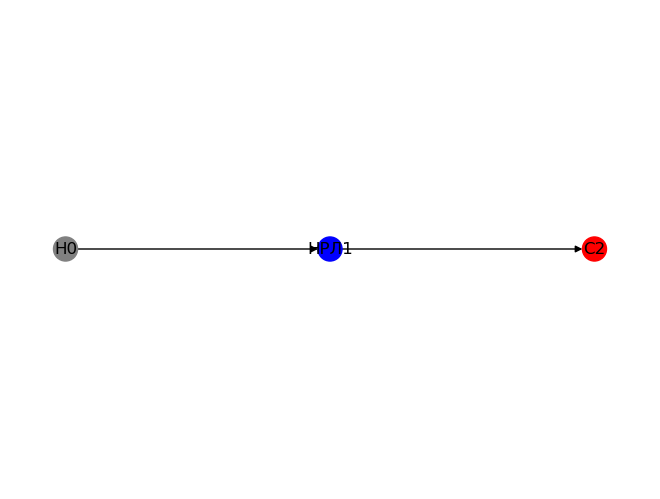

In [3]:
class Presets():

    @staticmethod
    def single_line():
        '''
        Простая НРС с одной РРЛ и одним стволом

            |=|>-------------|->
        '''
        p_nozzleB = NRS_Revision.calc_p(3.7, 40)

        pump = GA_Element_Pump('', e_type=1, H_add=40)
        hose = GA_Element_Hose('', e_type=1, s=NRS_Data.ss["51"], n=2)
        nozzle = GA_Element_Nozzle('', e_type=2, n_type='Б', p=p_nozzleB, q_out = q_out_nozzle)

        pump.append(hose).append(nozzle)

        model = GA_model('Простая НРС с одной РРЛ и одним стволом')
        model.addElements([pump,hose,nozzle])
        return model.check_pumps().interpretate()
    
    @staticmethod
    def single_splitter(nozzles_count=2):
        '''
        Сложная НРС с одним разветвлением и nozzles_count рабочих линий

                             ------|->
            |=|>------{------|->
                             ------|->
            
        '''
        if not nozzles_count in [1,2,3]:
            raise ValueError("Количество стволов не может быть меньше 1 и больше 3!")

        p_nozzleB = NRS_Revision.calc_p(3.7, 40)

        model = GA_model('Сложная НРС с одним разветвлением и nozzles_count рабочих линий')

        pump = GA_Element_Pump('', e_type=1, H_add=40)
        hoseM = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        spliiter = GA_Element_Splitter('', e_type=1, ri=1, ro=3)
        pump.append(hoseM).append(spliiter)

        model.addElements([pump,hoseM,spliiter])

        for _ in range(nozzles_count):
            hoseW = GA_Element_Hose('', e_type=1, d='51', s=NRS_Data.ss["51"], n=2)
            nozzle = GA_Element_Nozzle('', e_type=2, n_type='Б', p=p_nozzleB, q_out = q_out_nozzle)
            spliiter.append(hoseW).append(nozzle)
            model.addElements([hoseW,nozzle])

        return model.check_pumps().interpretate()
    
    @staticmethod
    def two_splitter(nozzles_count1=2, nozzles_count2=2):
        '''
        Сложная НРС с двумя разветвлениями и nozzles_count рабочих линий первого и второго порядка

                             ------|->          ------|->
            |=|>------{------------------{------|->
                             ------|->          ------|->
            
        '''
        if not nozzles_count1 in [1,2]:
            raise ValueError("Количество стволов не может быть меньше 1 и больше 2!")
        if not nozzles_count2 in [1,2,3]:
            raise ValueError("Количество стволов не может быть меньше 1 и больше 3!")

        p_nozzleB = NRS_Revision.calc_p(3.7, 40)

        model = GA_model('Сложная НРС с двумя разветвлениями и nozzles_count рабочих линий первого и второго порядка')

        pump = GA_Element_Pump('', e_type=1, H_add=40)
        hoseM1 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        spliiter1 = GA_Element_Splitter('', e_type=1, ri=1, ro=3)
        hoseM2 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        spliiter2 = GA_Element_Splitter('', e_type=1, ri=1, ro=3)
        pump.append(hoseM1).append(spliiter1).append(hoseM2).append(spliiter2)

        model.addElements([pump,hoseM1,spliiter1,hoseM2,spliiter2])

        for _ in range(nozzles_count1):
            hoseW = GA_Element_Hose('', e_type=1, d='51', s=NRS_Data.ss["51"], n=2)
            nozzle = GA_Element_Nozzle('', e_type=2, n_type='Б', p=p_nozzleB, q_out = q_out_nozzle)
            spliiter1.append(hoseW).append(nozzle)
            model.addElements([hoseW,nozzle])
        for _ in range(nozzles_count2):
            hoseW = GA_Element_Hose('', e_type=1, d='51', s=NRS_Data.ss["51"], n=2)
            nozzle = GA_Element_Nozzle('', e_type=2, n_type='Б', p=p_nozzleB, q_out = q_out_nozzle)
            spliiter2.append(hoseW).append(nozzle)
            model.addElements([hoseW,nozzle])
        
        return model.check_pumps().interpretate()

    @staticmethod
    def single_joiner(nozzle_q=20, nozzle_workpress=60):
        '''
        Сложная НРС с одним водосборником и лафетным стволом

            |=|>------
                             }------|-,->
            |=|>------
            
        '''

        p_nozzleL = NRS_Revision.calc_p(nozzle_q, nozzle_workpress)

        model = GA_model('Сложная НРС с одним водосборником и лафетным стволом')

        pump1 = GA_Element_Pump('', e_type=1, H_add=80)
        hoseM1 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        pump2 = GA_Element_Pump('', e_type=1, H_add=80)
        hoseM2 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        joiner = GA_Element_Joiner('', e_type=1, ri=2, ro=1)
        hoseW1 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        nozzle = GA_Element_Nozzle('', e_type=2, n_type='Л', p=p_nozzleL, q_out = q_out_nozzle)

        pump1.append(hoseM1).append(joiner)
        pump2.append(hoseM2).append(joiner)
        joiner.append(hoseW1).append(nozzle)

        model.addElements([pump1,hoseM1,pump2,hoseM2,joiner,hoseW1,nozzle])

        return model.check_pumps().interpretate()
    
    @staticmethod
    def n_components(n=2):
        '''
        Простая НРС из n компонентов в виде простых НРС

            n * |=|>-------------|->
            
        '''
        model = GA_model(f'Простая НРС из {n} компонентов в виде простых НРС')

        for _ in range(n):
            for e in Presets.single_line().elmnts:
                e.name=''
                model.addElements([e])

        return model.check_pumps().interpretate()


model = Presets.single_line()
print_NRS_graph(model)

Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Расстояние до Н0 80 м


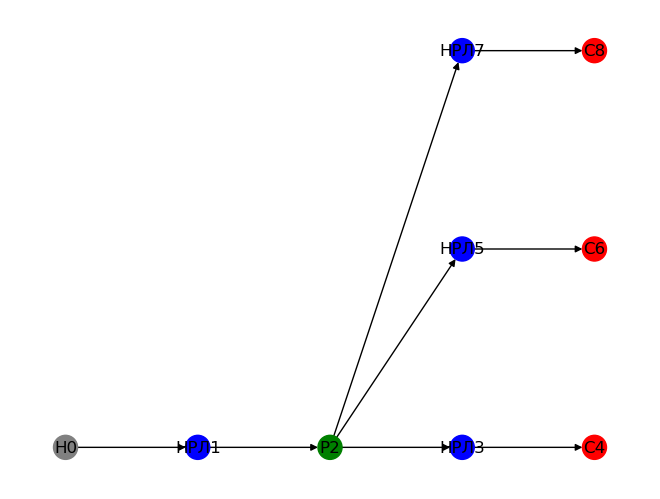

In [4]:
model = Presets.single_splitter(3)
print_NRS_graph(model)

Новая модель: Сложная НРС с двумя разветвлениями и nozzles_count рабочих линий первого и второго порядка
Расстояние до Н0 120 м


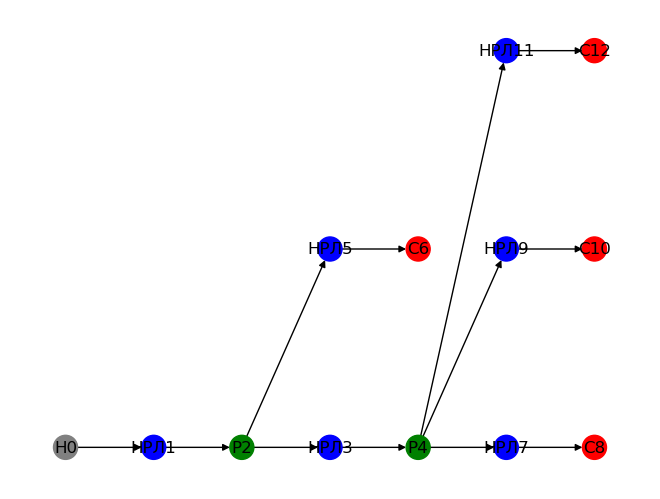

In [5]:
model = Presets.two_splitter(nozzles_count1=1, nozzles_count2=3)
print_NRS_graph(model)

Новая модель: Сложная НРС с одним водосборником и лафетным стволом
Расстояние до Н0 80 м
Расстояние до Н2 80 м


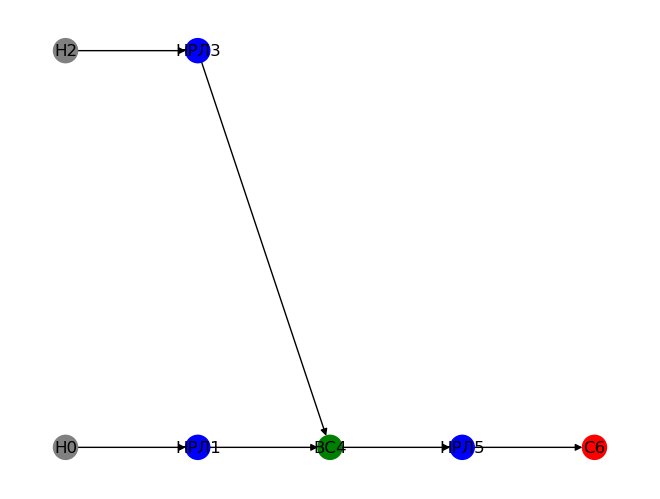

In [6]:
model = Presets.single_joiner(30)
print_NRS_graph(model)

Новая модель: Простая НРС из 3 компонентов в виде простых НРС
Новая модель: Простая НРС с одной РРЛ и одним стволом
Новая модель: Простая НРС с одной РРЛ и одним стволом
Новая модель: Простая НРС с одной РРЛ и одним стволом
Расстояние до Н0 40 м
Расстояние до Н3 40 м
Расстояние до Н6 40 м


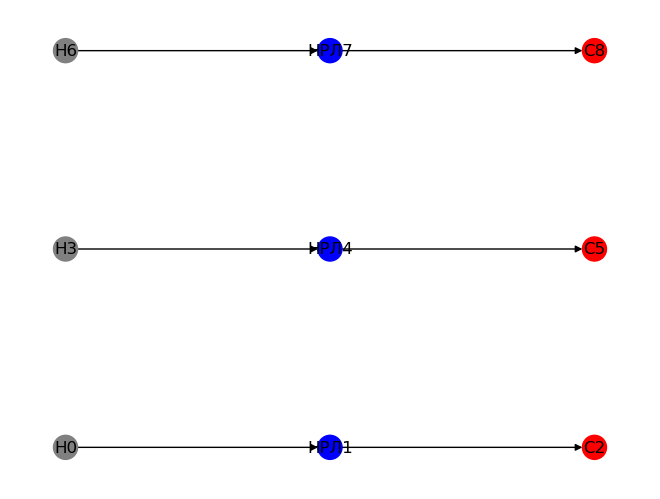

In [7]:
model = Presets.n_components(3)
print_NRS_graph(model)

In [8]:
# Расчет
try:
    model.calc(accuracy=0.05)
except Exception as e:
    print(e.args[0])
print(f'Общий расход системы: {model.summaryQ()} л/с', end='\n\n')

# Состав
NRS_Revision.print_model_elements(model)
Appraiser.print_GA_NRS_model_elements_state(model)

Общий расход системы: 10.640572147070957 л/с

all:
  Н0
  НРЛ1
  С2
  Н3
  НРЛ4
  С5
  Н6
  НРЛ7
  С8
in:
  Н0
  Н3
  Н6
out:
  С2
  С5
  С8
Простая НРС из 3 компонентов в виде простых НРС
Насос (Н0); напор: 40 м; производительность: 3.5468573823569858 л/с; напор макс.: 100
Насос (Н3); напор: 40 м; производительность: 3.5468573823569858 л/с; напор макс.: 100
Насос (Н6); напор: 40 м; производительность: 3.5468573823569858 л/с; напор макс.: 100

Рукавная линия (НРЛ1), длина: 40 м; диаметр: 51 мм; сопротивление 0.13; потеря напора: 3.2426667909999995 м
Рукавная линия (НРЛ4), длина: 40 м; диаметр: 51 мм; сопротивление 0.13; потеря напора: 3.2426667909999995 м
Рукавная линия (НРЛ7), длина: 40 м; диаметр: 51 мм; сопротивление 0.13; потеря напора: 3.2426667909999995 м

Ствол (С2): "Б"; проводимость: 0.5850213671311502; напор: 36.757333209, м; расход: 3.5468573823569858, л/с
Ствол (С5): "Б"; проводимость: 0.5850213671311502; напор: 36.757333209, м; расход: 3.5468573823569858, л/с
Ствол (С8): "

# Тесты

In [9]:
# p_nozzleB = NRS_Revision.calc_p(3.7, 40)
# p_nozzleA = NRS_Revision.calc_p(7.4, 40)
# p_nozzleL = NRS_Revision.calc_p(16, 40)
# p_nozzleB, p_nozzleA, p_nozzleL

# Мутации

## Тест макромутаций

Макромутации - мутации в структуре модели. Добавление, изменение и удаление элементов модели.

## Тест корректного удаления элементов

Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Расстояние до Н0 80 м


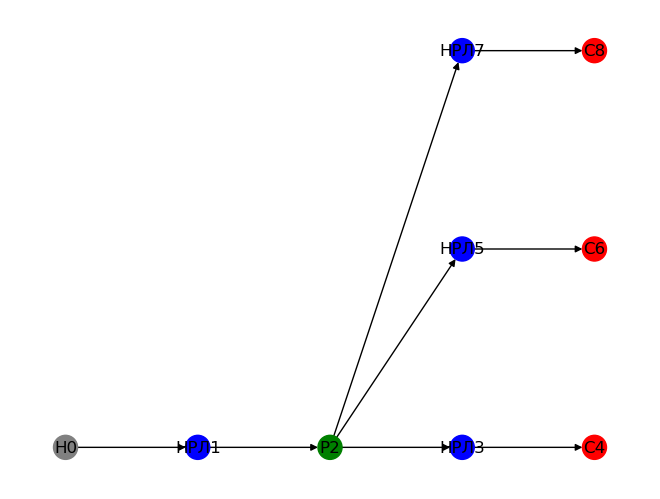

In [10]:
model = Presets.single_splitter(3)
print_NRS_graph(model)

Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Расстояние до Н0 80 м


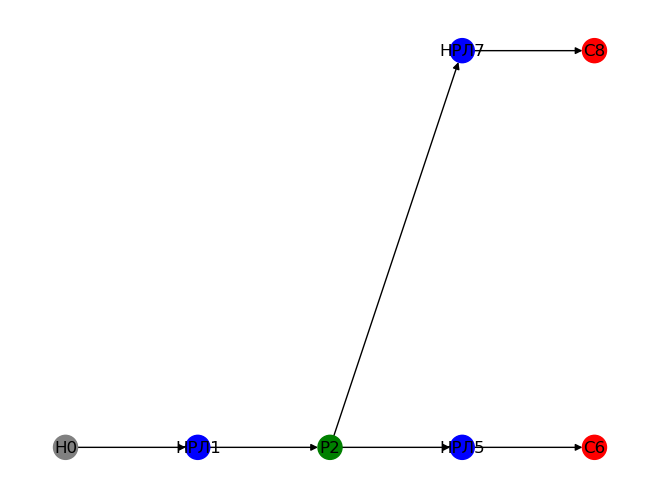

In [11]:
model = Presets.single_splitter(3)
model.getElement('Р2').set_ro(2)
for e in model.elmnts:
    model.fire_dead_elements_try(e)
print_NRS_graph(model)

### Проверка обучения

С удалением ветвей

In [12]:
model = Presets.single_splitter(3)

Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий


In [13]:
aims = {'Q':15, '38дв':0, '51нп':0, '89':0,'110': 0, '150': 10, '200': 0, '225': 0, '250': 0, '300': 0, 'min_L': 800, 'max_L': 800}

curQ = Appraiser.evaluate(Appraiser.metrics(model), aims)
for i in range(2000):
    print(f'{i}\t', end='\r')
    model_back = copy.deepcopy(model)
    to_print = i%100==0
    try:
        model.mutate(mutation_count=2)
        for elmnt in model.elmnts:
            model.fire_dead_elements_try(elmnt)
        model.drop_q()
        kwargs = model.calc(accuracy=0.5)
        newQ = Appraiser.evaluate(Appraiser.metrics(model), aims)
        if newQ>curQ:
            model = model_back
        if newQ<curQ:
        # if to_print:
            curQ=newQ
            print(i, newQ, model.summaryQ(), sep='\t')
    except:
        # print(i, 'Модель не жизнеспособна')
        model = model_back

print('Итог:', curQ, model.summaryQ(), sep='\t')

0	0.7557426945653453	19.304293301141488
3	0.7082388823717435	15.511179120896442
5	0.708177008603017	14.509379483818975
6	0.6296226695974022	13.6669798681169
14	0.6243220134459009	13.90550939493446
23	0.6029863368608828	14.865614841260275
46	0.5792439458319157	14.809022437563794
66	0.5782380000326731	14.854289998529708
72	0.5717343187104383	14.771955658030276
87	0.5700414892486801	15.153420315223675
89	0.5524592830874075	14.88933226106666
115	0.5447757197821	14.860092609805502
133	0.5401653161477538	14.31756077335108
134	0.5214177645773264	15.161792370458745
140	0.398342447754764	15.28070332673634
153	0.39575935249734334	11.8794388501594
171	0.38956565863737164	11.876060481757701
182	0.37755892748918884	12.59646435064867
195	0.3606897620132814	11.358614279203113
215	0.3597057836396038	11.79265298162377
229	0.33516059930926373	11.765364041444176
256	0.32323525089027116	11.73088494658373
271	0.3126593588856263	12.365438466862422
311	0.3026003120741857	12.96898127554886
314	0.2904981621852

359	0.285540929990137	14.367544200591777
369	0.275763097848344	14.954214129099359
502	0.2632759328718345	14.95344402768993
529	0.2507124200221174	14.957254798672956
533	0.22679550522658468	15.108509632040938
614	0.22479557493329191	15.775894785920036
641	0.2145245880215657	14.878524718706057
659	0.19116188767314757	15.222979361895622
691	0.18846359565434523	15.445675428600724
740	0.18318624560224533	14.88382526386528
Итог:	0.18318624560224533	14.88382526386528


Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Насос (Н0); напор: 65 м; производительность: 14.88382526386528 л/с; напор макс.: 100

Рукавная линия (НРЛ1), длина: 120 м; диаметр: 77 мм; сопротивление 0.015; потеря напора: 20.88370314327344 м
Рукавная линия (НРЛ3), длина: 680 м; диаметр: 66 мм; сопротивление 0.034; потеря напора: 13.428110178542825 м
Рукавная линия (НРЛ5), длина: 100 м; диаметр: 150 мм; сопротивление 0.00046; потеря напора: 0.14282268567316342 м
Рукавная линия (НРЛ7), длина: 100 м; диаметр: 150 мм; сопротивление 0.00046; потеря напора: 0.03578617761002397 м

Ствол (С4): "Б"; проводимость: 0.5850213671311502; напор: 30.68818667818374, м; расход: 3.240838146314682, л/с
Ствол (С6): "А"; проводимость: 1.1700427342623003; напор: 43.9734741710534, м; расход: 7.7588456705989515, л/с
Ствол (С8): "Б"; проводимость: 0.5850213671311502; напор: 44.08051067911654, м; расход: 3.8841414469516473, л/с
hoses	50
nozzles	3
distances	{'Н0': {'С6': 220, 'С8': 220, 'С4': 800

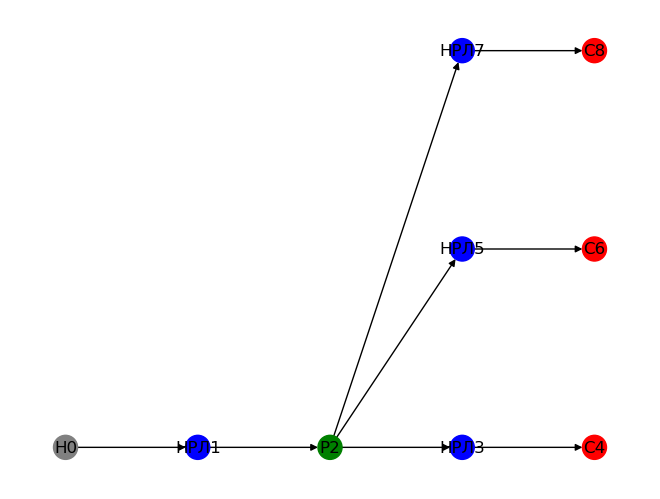

In [14]:
Appraiser.print_GA_NRS_model_elements_state(model)
print('='*80)
Appraiser.print_metrics(model)
print_NRS_graph(model)

## Класс ветви

In [15]:
class Branch(NRS_Model):
    '''
    Класс ветви модели. Может быть трех типов:

    `FULL=0` Имеет и источник и потребитель (насос и ствол).
        Например простая модель НРС АЦ->Рукав->Ствол.

    `INWARD=1` Имеет только вход. Выход открыт (оканчивается рукавом)
        Например, Рукавные линии начинающиеся от насосов. Могут подключаться на вход к водосборникам или насосам.

    `OUTWARD=2` Имеет только выход. Вход открыт (начинается с рукава). 
        Например, рабочие рукавные линии. Могут подключаться на выход к разветвлениям или насосам.

    `-1` Не распознана.
    '''

    def __init__(self, name=''):
        self.elmnts_names = []
        self._branch_type = -1
        super().__init__(name)

    def getBranch(self, model:NRS_Model, elmnt=None):
        '''
        Из `model` выделяется ветвь в которую входит элемент `elmnt`. 
        Если `elmnt` не передан, он выбирается случайно.
        '''
        # Если элемент не передан, выбираем его случайным образом
        if elmnt is None:
            elmnt = random.choice(model.elmnts)
        # Если передано имя элемента, получаем его по имени, иначе предполагается использование объекта
        if isinstance(elmnt, str):
            elmnt = model.getElement(elmnt)
        if not isinstance(elmnt, Element):
            raise TypeError('Должен быть элемент НРС!')

        self._elementAdd(elmnt)

        return self
    
        
    def _elementAdd(self, elmnt:Element):
        '''
        Рекурсивное добавление элементов в модель
            Вход:
                elmnt=Element: элемент который следует добавить модель. 
                Далее _elementAdd будет вызвана для всех подключенных к нему элементов
        '''
        if not elmnt in self.elmnts:
            self.addElements([elmnt])
            for linked in elmnt.elements_next:
                if isinstance(linked, (GA_Element_Hose, GA_Element_Nozzle)):
                    self._elementAdd(linked)
            for linked in elmnt.elements_previous:
                if isinstance(linked, (GA_Element_Hose, GA_Element_Pump)):
                    self._elementAdd(linked)

    def interpretate(self):

        super().interpretate()
        # Определение типа ветви
        if len(self.elmnts_in)==1 and len(self.elmnts_out)==1:
            self._branch_type = 0
        elif len(self.elmnts_in)==1 and len(self.elmnts_out)==0:
            self._branch_type = 1
        elif  len(self.elmnts_in)==0 and len(self.elmnts_out)==1:
            self._branch_type = 2
        # Определение входных элементов
        for elmnt in self.elmnts:
            if len(self.elmnts_in) + len(self.elmnts_out) ==1:
                self.plugin = elmnt

        return self
    
    @property
    def branch_type(self):
        t = {0:'ПОЛНАЯ', 1:'ВХОДЯЩАЯ', 2:'ИСХОДЯЩАЯ'}
        return t[self._branch_type]
    
    def deep_copy(self):
        '''
        Делает глубокую копию элементов. Требуется для удаления связей с исходной моделью.
        '''
        tmp_col = []
        for elmnt in self.elmnts:
            # print(tmp_col, elmnt.name)
            tmp_col.append(copy.deepcopy(elmnt).drop_links())
        for elmnt in self.elmnts:
            # print(tmp_col, elmnt.name)
            elmnt_copy = NRS_Revision.get_element_by_name(tmp_col, elmnt.name, False)
            for linked in elmnt.elements_next:
                linked_copy = NRS_Revision.get_element_by_name(tmp_col, linked.name, False)
                if linked_copy:
                    elmnt_copy.append(linked_copy)
            for linked in elmnt.elements_previous:
                linked_copy = NRS_Revision.get_element_by_name(tmp_col, linked.name, False)
                if linked_copy:
                    linked_copy.append(elmnt_copy)

        self.elmnts = tmp_col
        
        return self
    
    def drop_names(self):
        '''
        Обезличивает (удаляет имена) элементов ветви.
        Требуется для корректной передачи в другие модели, где элементы будут переименованы в соответствии с моделью.
        '''
        for elmnt in self.elmnts:
            elmnt.name = ''
        return self
    
    def plug(self, elmnt):
        '''
        Прививает ветвь к указанному элементу.

        Если ветвь входящая, то прививается на вход (если возможно). 
        Если исходящая - на выход (если возможно)
        Если полная или нераспознанная, ничего не происходит
        '''
        # ВХОДЯЩАЯ
        if self._branch_type==1:
            self.plugin.append(elmnt)
        # ИСХОДЯЩАЯ
        if self._branch_type==2:
            elmnt.append(self.plugin)

        return self


# Рассматриваемая модель НРС
model = Presets.single_splitter(3)

branch = Branch().getBranch(model, 'НРЛ1').deep_copy().interpretate()  #.check_pumps().interpretate()
NRS_Revision.print_model_elements(branch)


# print_NRS_graph(branch)
print(branch.branch_type)

Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Новая модель: 
all:
  НРЛ1
  Н0
in:
  Н0
out:
ВХОДЯЩАЯ


In [16]:
Appraiser.print_GA_NRS_model_elements_state(branch)


Насос (Н0); напор: 40 м; производительность: 0 л/с; напор макс.: 100

Рукавная линия (НРЛ1), длина: 40 м; диаметр: 77 мм; сопротивление 0.015; потеря напора: 0 м



Расстояние до Н0 80 м


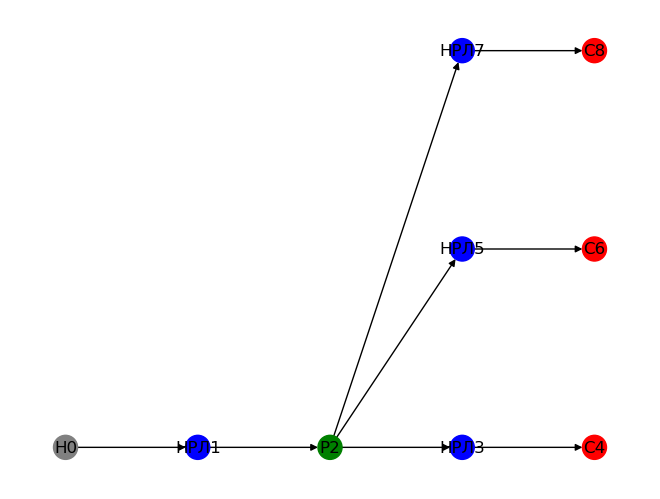

Расстояние до Н0 0 м


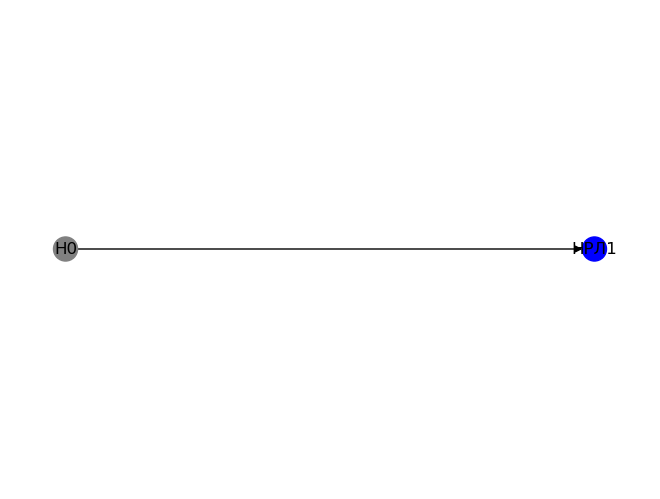

In [17]:
print_NRS_graph(model)
print_NRS_graph(branch)

### Прививка ветви другой модели (на выход)

Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий
all:
  Н0
  НРЛ1
  Р2
  НРЛ3
  С4
  НРЛ5
  С6
in:
  Н0
out:
  С4
  С6
Модель для прививки
Насос (Н0); напор: 40 м; производительность: 0 л/с; напор макс.: 100

Рукавная линия (НРЛ1), длина: 40 м; диаметр: 77 мм; сопротивление 0.015; потеря напора: 0 м
Рукавная линия (НРЛ3), длина: 40 м; диаметр: 51 мм; сопротивление 0.13; потеря напора: 0 м
Рукавная линия (НРЛ5), длина: 40 м; диаметр: 51 мм; сопротивление 0.13; потеря напора: 0 м

Ствол (С4): "Б"; проводимость: 0.5850213671311502; напор: 0, м; расход: 0, л/с
Ствол (С6): "Б"; проводимость: 0.5850213671311502; напор: 0, м; расход: 0, л/с
Расстояние до Н0 80 м


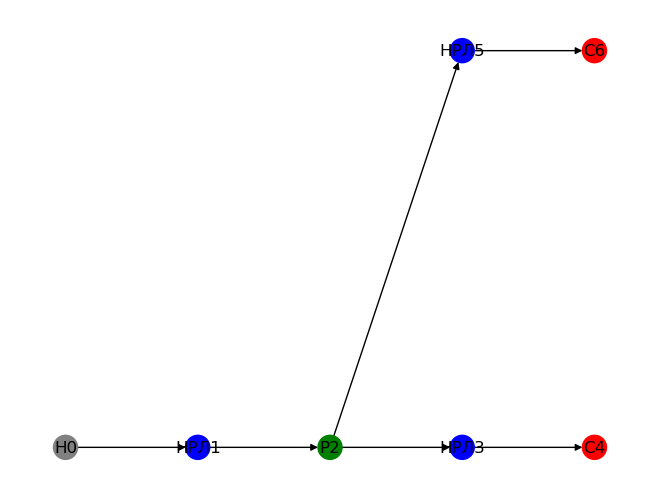

Новая модель: 
all:
  С6
  НРЛ5
in:
out:
  С6
ИСХОДЯЩАЯ


In [18]:
# Модель у которой получаем ветвь
model1 = Presets.single_splitter(3)
# Модель которой будем ее прививать
model2 = Presets.single_splitter()
model2.name = 'Модель для прививки'
NRS_Revision.print_model_elements(model2)
Appraiser.print_GA_NRS_model_elements_state(model2)
print_NRS_graph(model2)

# Получение ветви
branch = Branch().getBranch(model1, 'С6').deep_copy().interpretate()
NRS_Revision.print_model_elements(branch)
print(branch.branch_type)

# Прививка ветви
branch.drop_names().plug(NRS_Revision.get_element_by_name(model2.elmnts, 'Р2', False))
model2.addElements(branch.elmnts).interpretate().check_pumps()

all:
  Н0
  НРЛ1
  Р2
  НРЛ3
  С4
  НРЛ5
  С6
  С7
  НРЛ8
in:
  Н0
out:
  С4
  С6
  С7
Расстояние до Н0 80 м


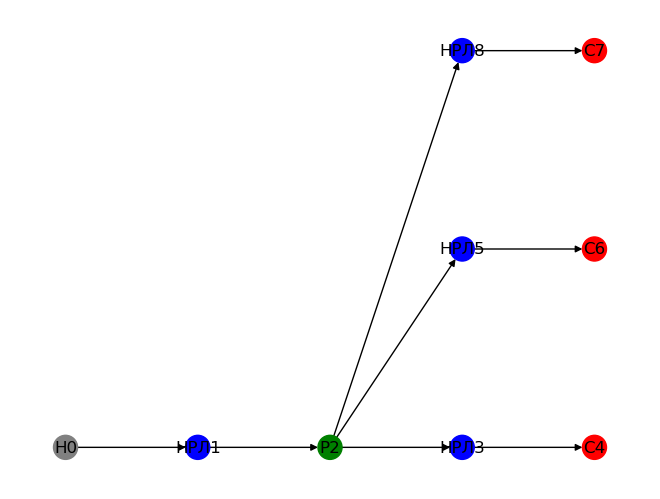

In [19]:
NRS_Revision.print_model_elements(model2)
print_NRS_graph(model2)

all:
  Н0
  НРЛ1
  Р2
  НРЛ3
  С4
  НРЛ5
  С6
  С7
  НРЛ8
in:
  Н0
out:
  С4
  С6
  С7
Расстояние до Н0 80 м


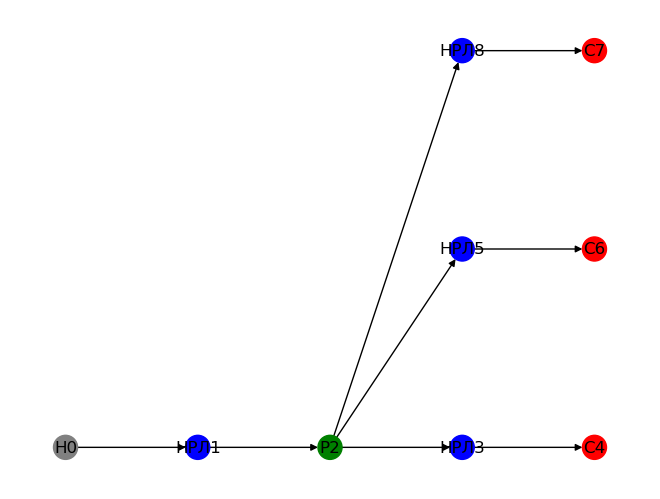

0	0.5826167350795141	9.782246921421866
6	0.5777900343241585	9.999448455412866
13	0.5204286743700802	12.58070965334639
29	0.46726291894893396	14.973168647297973
89	0.43982240548534374	15.297805694762246
92	0.37732005391731943	15.49523005907174
98	0.3526588675753097	14.130350959111066


135	0.34704826299340535	14.382828165296758
145	0.3354752036847793	15.097007498268296
168	0.3144321885593475	15.918983060827701
183	0.23943062126120387	15.91887714811216
253	0.2358757203405102	15.682221836025837
269	0.23319821791536627	15.508570564163385
287	0.2290411728213458	15.246454225756073
361	0.21535470281906408	15.17326059922804
476	0.18591509460720507	12.095094323567695
506	0.17842614722681674	12.544431166390995
563	0.17821199701264834	12.557280179241099
580	0.16799689065100448	13.17018656093973
624	0.15823647949723782	13.75581123016573
625	0.1534270087362389	14.044379475825664
632	0.15053969734760939	14.217618159143436
649	0.14822231126372307	13.606661324176615
653	0.11933976060798832	12.303900077806416
673	0.1122232890516528	12.730888371186547
715	0.09956922216193467	12.740132384569634
764	0.09804782678445265	12.831416107218555
770	0.08931540660977069	13.355361317699472
784	0.07297576433109057	14.33573985442028
789	0.06458975337408668	14.838900511840514
870	0.0604443170787037

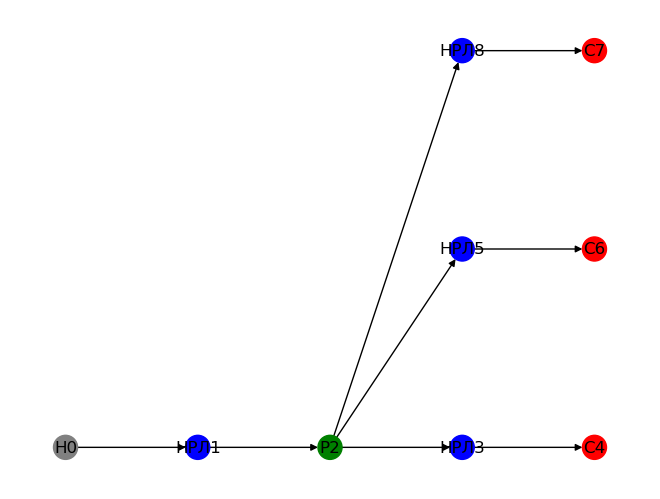

In [20]:
def fit(model, aims, epochs=1000):
    curQ = Appraiser.evaluate(Appraiser.metrics(model), aims)
    for i in range(epochs):
        print(f'{i}\t', end='\r')
        model_back = copy.deepcopy(model)
        try:
            model.mutate(mutation_count=2)
            for elmnt in model.elmnts:
                model.fire_dead_elements_try(elmnt)
            model.drop_q()
            kwargs = model.calc(accuracy=0.5)
            newQ = Appraiser.evaluate(Appraiser.metrics(model), aims)
            if newQ>curQ:
                model = model_back
            if newQ<curQ:
                curQ=newQ
                print(i, newQ, model.summaryQ(), sep='\t')
        except:
            # print(i, 'Модель не жизнеспособна')
            model = model_back

    print('Итог:', curQ, model.summaryQ(), sep='\t')
    return model


work_model = copy.deepcopy(model2)

NRS_Revision.print_model_elements(work_model)
print_NRS_graph(work_model)

aims = {'Q':15, '38дв':0, '51нп':0, '89':0,'110': 0, '150': 10, '200': 0, '225': 0, '250': 0, '300': 0, 'min_L': 400, 'max_L': 400}
work_model = fit(work_model, aims)

NRS_Revision.print_model_elements(work_model)
print_NRS_graph(work_model)

In [24]:
Appraiser.print_GA_NRS_model_elements_state(work_model)
print('='*80)
Appraiser.print_metrics(work_model)
print('='*80)
aims

Модель для прививки
Насос (Н0); напор: 80 м; производительность: 14.835347267063238 л/с; напор макс.: 100

Рукавная линия (НРЛ1), длина: 220 м; диаметр: 77 мм; сопротивление 0.015; потеря напора: 38.80007264331307 м
Рукавная линия (НРЛ3), длина: 200 м; диаметр: 150 мм; сопротивление 0.00046; потеря напора: 0.27470941097794227 м
Рукавная линия (НРЛ5), длина: 160 м; диаметр: 77 мм; сопротивление 0.015; потеря напора: 1.7359158503133216 м
Рукавная линия (НРЛ8), длина: 160 м; диаметр: 77 мм; сопротивление 0.015; потеря напора: 1.7359158503133216 м

Ствол (С4): "А"; проводимость: 1.1700427342623003; напор: 40.92521794570899, м; расход: 7.485093410751506, л/с
Ствол (С6): "Б"; проводимость: 0.5850213671311502; напор: 39.46401150637361, м; расход: 3.6751269281558656, л/с
Ствол (С7): "Б"; проводимость: 0.5850213671311502; напор: 39.46401150637361, м; расход: 3.6751269281558656, л/с
hoses	37
nozzles	3
distances	{'Н0': {'С6': 380, 'С7': 380, 'С4': 420}}
min_L	380
max_L	420
77	27
150	10
А	1
Б	2
Q	

{'Q': 15,
 '38дв': 0,
 '51нп': 0,
 '89': 0,
 '110': 0,
 '150': 10,
 '200': 0,
 '225': 0,
 '250': 0,
 '300': 0,
 'min_L': 400,
 'max_L': 400}

### Прививка ко входу другой модели

Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Новая модель: Сложная НРС с одним водосборником и лафетным стволом
Модель для прививки
Насос (Н0); напор: 80 м; производительность: 0 л/с; напор макс.: 100
Насос (Н2); напор: 80 м; производительность: 0 л/с; напор макс.: 100

Рукавная линия (НРЛ1), длина: 40 м; диаметр: 77 мм; сопротивление 0.015; потеря напора: 0 м
Рукавная линия (НРЛ3), длина: 40 м; диаметр: 77 мм; сопротивление 0.015; потеря напора: 0 м
Рукавная линия (НРЛ5), длина: 40 м; диаметр: 77 мм; сопротивление 0.015; потеря напора: 0 м

Ствол (С6): "Л"; проводимость: 2.581988897471611; напор: 0, м; расход: 0, л/с
Расстояние до Н0 80 м
Расстояние до Н2 80 м


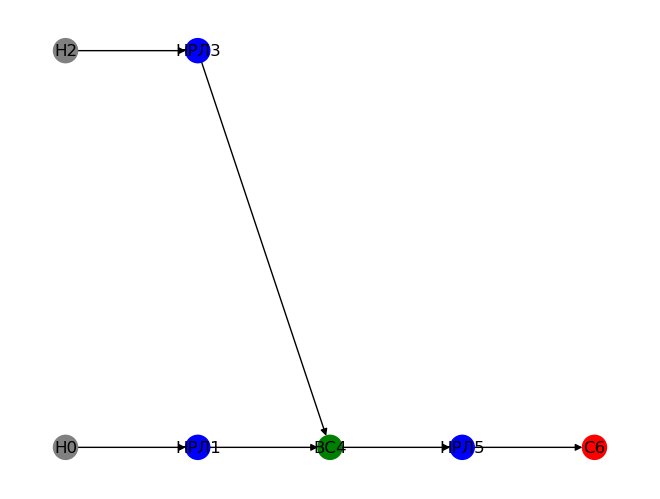

Новая модель: 
all:
  Н0
  НРЛ1
in:
  Н0
out:
ВХОДЯЩАЯ
Модель для прививки
Насос (Н0); напор: 80 м; производительность: 0 л/с; напор макс.: 100
Насос (Н7); напор: 40 м; производительность: 0 л/с; напор макс.: 100

Рукавная линия (НРЛ1), длина: 40 м; диаметр: 77 мм; сопротивление 0.015; потеря напора: 0 м
Рукавная линия (НРЛ5), длина: 40 м; диаметр: 77 мм; сопротивление 0.015; потеря напора: 0 м
Рукавная линия (НРЛ8), длина: 40 м; диаметр: 77 мм; сопротивление 0.015; потеря напора: 0 м

Ствол (С6): "Л"; проводимость: 2.581988897471611; напор: 0, м; расход: 0, л/с
Расстояние до Н0 80 м
Расстояние до Н7 80 м


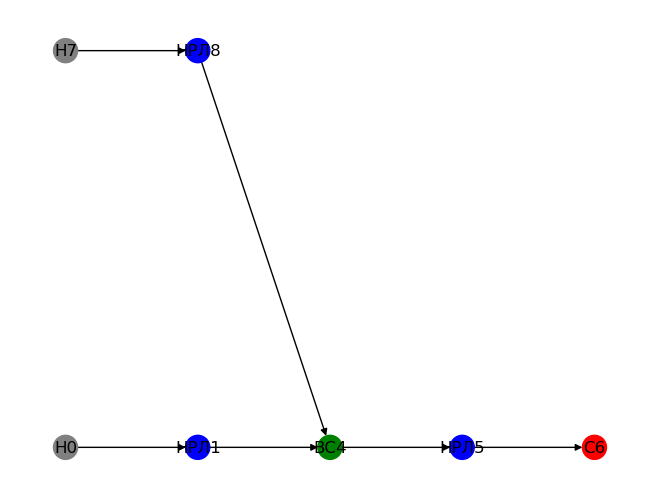

In [29]:
# Модель у которой получаем ветвь
model1 = Presets.single_splitter(3)
# Модель которой будем ее прививать
model2 = Presets.single_joiner()
model2.name = 'Модель для прививки'
# NRS_Revision.print_model_elements(model2)
Appraiser.print_GA_NRS_model_elements_state(model2)
print_NRS_graph(model2)

# Удаление одной из ветвей
model2.delElement(NRS_Revision.get_element_by_name(model2.elmnts, 'Н2', False))
# Appraiser.print_GA_NRS_model_elements_state(model2)
# print_NRS_graph(model2)

# Получение ветви
branch = Branch().getBranch(model1, 'Н0').deep_copy().interpretate()
NRS_Revision.print_model_elements(branch)
print(branch.branch_type)

# Прививка ветви
branch.drop_names().plug(NRS_Revision.get_element_by_name(model2.elmnts, 'ВС4', False))
model2.addElements(branch.elmnts).interpretate().check_pumps()
Appraiser.print_GA_NRS_model_elements_state(model2)
print_NRS_graph(model2)

In [32]:
# Проверка расчета
aims = {'Q':15, '38дв':0, '51нп':0, '66нп':0, '89':0, '150': 10, '200': 0, '225': 0, '250': 0, '300': 0, 'min_L': 400, 'max_L': 400}
work_model = copy.deepcopy(model2)
work_model = fit(work_model, aims)

# Печать результатов
Appraiser.print_GA_NRS_model_elements_state(work_model)
print('='*80)
Appraiser.print_metrics(work_model)
print('='*80)
aims

0	0.5427248947308166	14.577379737113251
7	0.4729781156120228	13.215984797458974
8	0.45516291765528133	14.01766870551234
13	0.4384962509886147	14.01766870551234
17	0.4216462178141995	14.775920198361025
22	0.3730157869930395	13.964289585313223
25	0.35786954498918205	14.645870475486806
34	0.3154758790199152	14.821447258805089
36	0.26010623144851386	13.643626113089168
56	0.18283350417578662	13.643626113089168
77	0.17244993337871936	13.653003997276839
136	0.16233170674002756	14.260097595598348
159	0.1549711610248026	15.304320975783535
233	0.1522714878688612	15.137538944305614
496	0.13648448844844607	14.310930693093235
530	0.1306128373347029	15.344504838561633
568	0.12954264778349817	8.727441132990112
575	0.12443733632339274	9.033759820596437
609	0.12186095311256259	9.188342813246246
631	0.11714788356917005	9.471126985849798
649	0.09876397045035426	10.574161772978746
654	0.09365462168661426	10.880722698803146
663	0.06395097337785235	11.162941597328858
708	0.05911772625916195	11.4529364244502

{'Q': 15,
 '38дв': 0,
 '51нп': 0,
 '66нп': 0,
 '89': 0,
 '150': 10,
 '200': 0,
 '225': 0,
 '250': 0,
 '300': 0,
 'min_L': 400,
 'max_L': 400}